<a href="https://colab.research.google.com/github/siddadel/kalidas/blob/main/Collate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
root = '/content/drive/MyDrive/ANLP21/'

In [6]:
import pandas as pd
import random
import os
import re
import spacy
from collections import Counter
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
nlp = spacy.load("en_core_web_sm")
df = pd.concat([pd.read_csv(root+'concatenated/concatenated-%s.csv' % i) for i in range(1,5)])
df.head()

In [3]:
df.to_csv(root+'concatenated.csv')

In [4]:
relations = [ "xAttr",  "MotivatedByGoal", "xReact"]

vocabulary = set()

film_bags = {}

def register_in_bag(film, token, relation):
    if film not in film_bags:
      film_bags[film] = {}
    if(relation not in film_bags[film]):
      film_bags[film][relation] = set()
    film_bags[film][relation].add(token)
    vocabulary.add(token)
    
def process_results(row):
    for relation in relations:
      film = row['film']
      results = row[relation].strip('][').split(', ')
      for result in results:
        tokens = result.split(' ')

        for token in tokens:
            token = token.replace('\'','').strip()
            if token != "" and token not in nlp.Defaults.stop_words:
              register_in_bag(film, token, relation)


df.apply(process_results, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
14458    None
14459    None
14460    None
14461    None
14462    None
Length: 87179, dtype: object

In [20]:
def vectorize(function_vec, vocabulary):
  vocabulary = list(vocabulary)
  film_vectors = []
  for film in film_bags:
    relation_bag = [] 
    for relation in film_bags[film]:
      vec = function_vec(film_bags[film][relation])
      d = len(vec)
      relation_bag.append(vec)
    film_vectors.append(relation_bag)

  X = np.array(film_vectors)
  w, h, d = len(film_vectors), len(relations), d
  assert X.shape == (w, h, d)
  print(w, h, d)
  return X, w, h, d

In [21]:
import re
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath

# First we have to convert the Glove format into w2v format; this creates a new file
glove_file= root+"/glove.6B.100d.100K.txt"
glove_in_w2v_format= root+"/glove.6B.100d.100K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)

glove = KeyedVectors.load_word2vec_format(root+"/glove.6B.100d.100K.w2v.txt", binary=False)

In [14]:
def plot_3d(X, w, h, d):
  X = X.reshape((w,h*d))

  tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  z = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      z.append(value[2])
          
  plt.figure(figsize=(16, 16)) 
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z, cmap='viridis')


def plot_2d(X, w, h, d):
  assert X.shape == (w, h, d)
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
          
  plt.figure(figsize=(16, 16)) 
  plt.scatter(x,y, cmap='viridis')
  plt.show()

In [28]:
bag_of_words = lambda inference: [1 if token in inference else 0 for token in vocabulary]
X, w, h, d = vectorize(bag_of_words, vocabulary)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


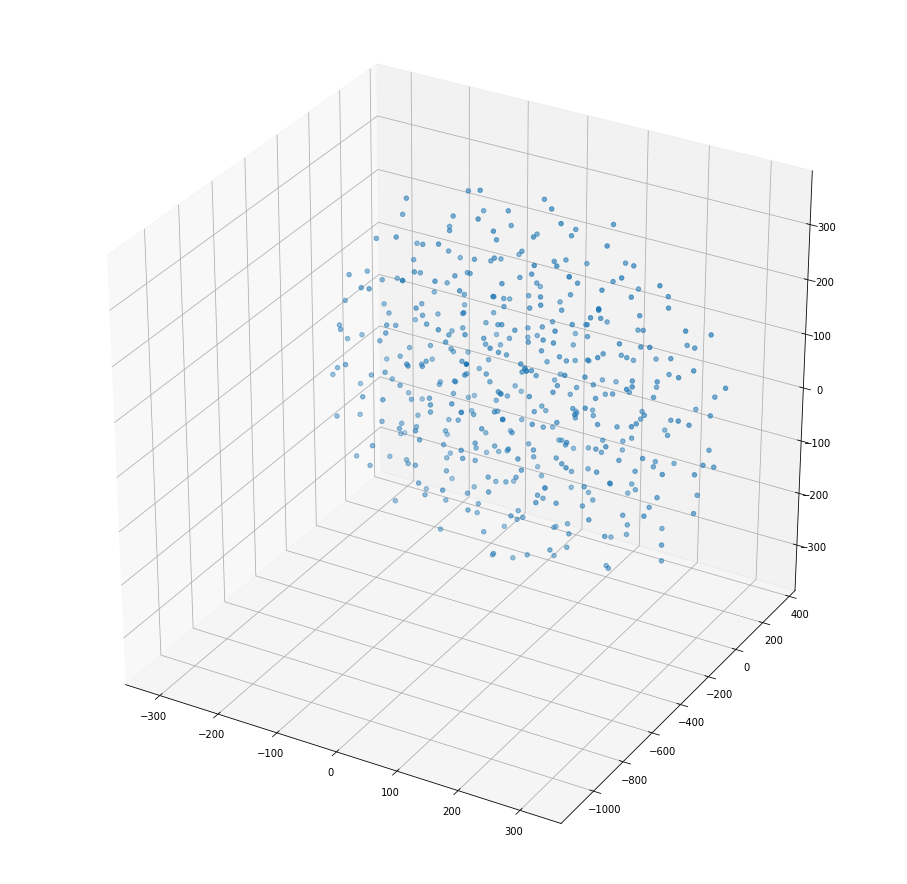

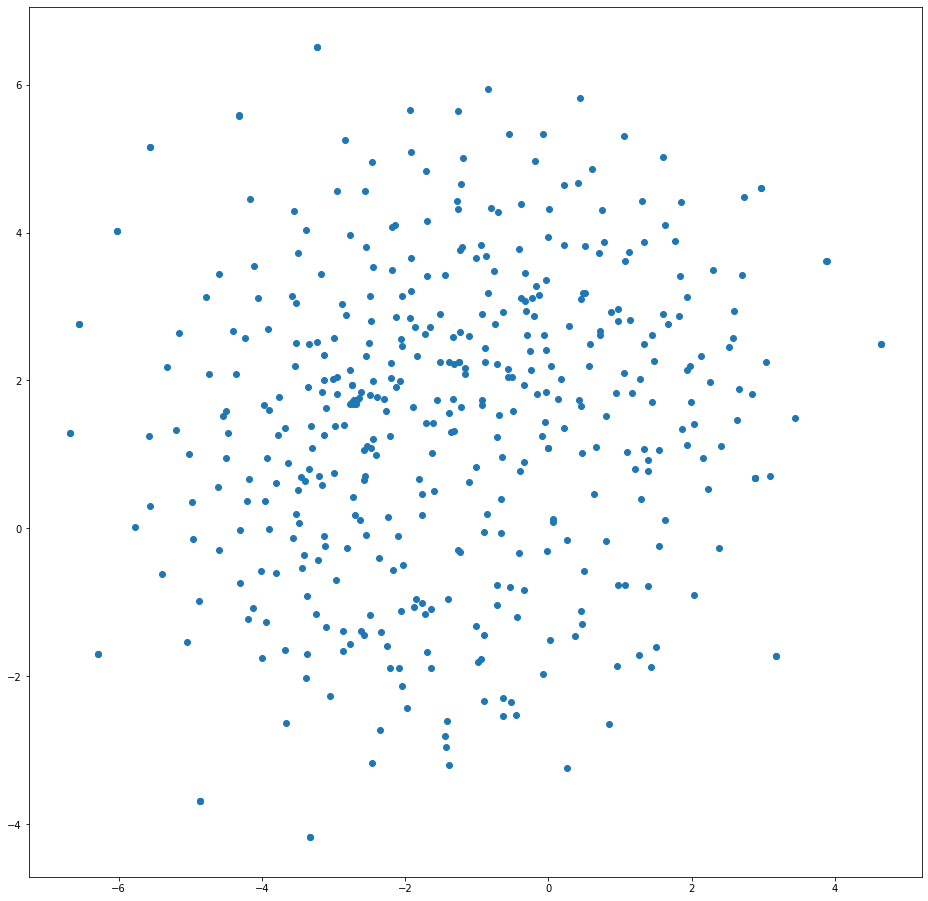

In [33]:
glovec =  lambda inference: np.mean([glove[token] for token in inference if token in glove], axis=0).tolist()
X, w, h, d = vectorize(bag_of_words, vocabulary)